In [27]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance
import matplotlib.image as mpimg
from sklearn.metrics import r2_score, mean_squared_error

# Gather datasets

In [28]:
data = pd.read_pickle('saved-metrics.pkl')
cmaps = ["light:#03012d","light:#d99e09"]
cmaps2 = ["#03012d","#d99e09"]


# IC 1

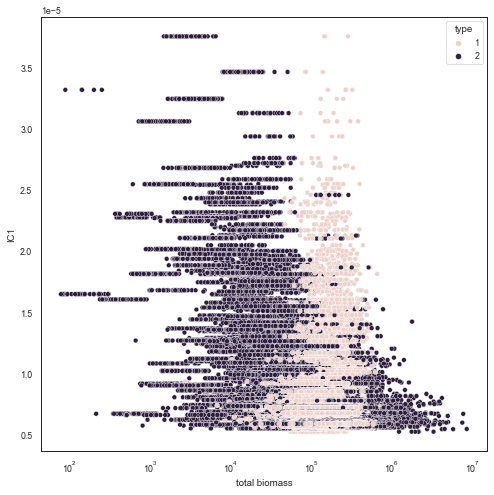

In [29]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='total biomass',y='IC1',hue='type',data=data,ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()


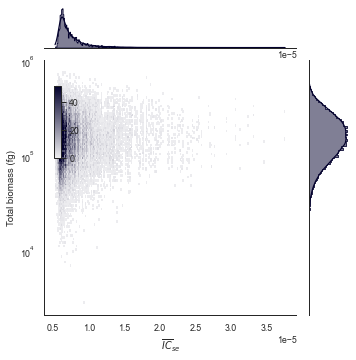

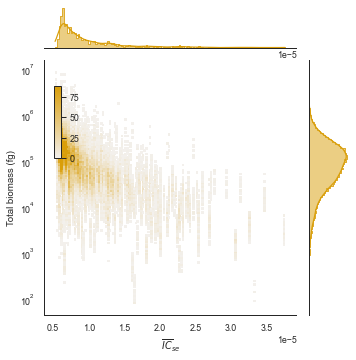

In [30]:
types = [r'$\it{S. elongatus}$',r'$\it{E. coli W}$']
for i in [1,2]:
    data2 = data[data.type==i]
    g = sns.JointGrid(data=data2, x="IC1",y="total biomass", height=5,space=0.3)
    """     if i==1:
        g.fig.suptitle(r'$\it{S. elongatus}$')
    elif i ==2:
        g.fig.suptitle(r'$\it{E. coli W}$') """
    g.ax_joint.set(yscale="log")
    #g.ax_joint.set(yscale="log")
    cax = g.fig.add_axes([.15, .55, .02, .2])
    g.plot_joint(
        sns.histplot, 
        cmap=cmaps[i-1], cbar=True, cbar_ax=cax,pmax=.8)
    g.plot_marginals(sns.histplot, element="step", color=cmaps2[i-1],kde=True)
    g.ax_joint.set_xlabel(r' $\overline{IC}_{se}$')
    g.ax_joint.set_ylabel('Total biomass (fg)')
    g.savefig(f'../figures/IC1_{i}.png',dpi=600)

# IC 2

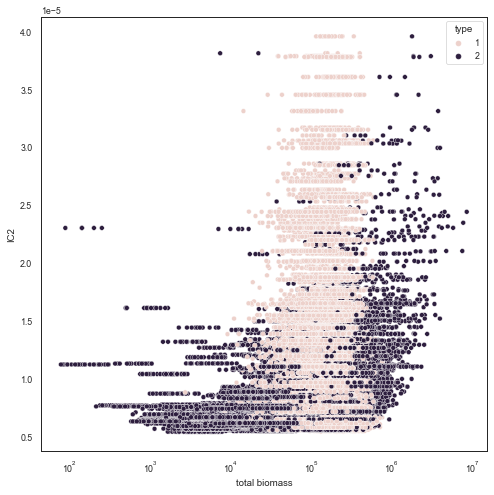

In [31]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='total biomass',y='IC2',hue='type',data=data,ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()


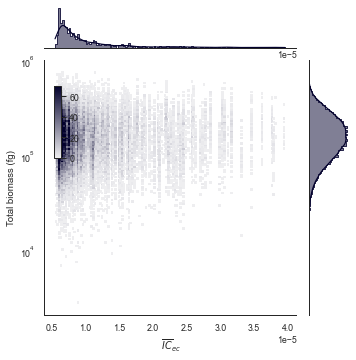

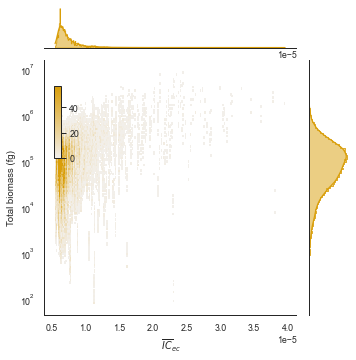

In [32]:
sns.set_context('paper')
for i in [1,2]:
    data2 = data[data.type==i]
    g = sns.JointGrid(data=data2, x="IC2",y="total biomass", height=5,space=0.3)
    """     if i==1:
        g.fig.suptitle(r'$\it{S. elongatus}$')
    elif i ==2:
        g.fig.suptitle(r'$\it{E. coli W}$') """
    g.ax_joint.set(yscale="log")
    #g.ax_joint.set(yscale="log")
    cax = g.fig.add_axes([.15, .55, .02, .2])
    g.plot_joint(
        sns.histplot, 
        cmap=cmaps[i-1], cbar=True, cbar_ax=cax,pmax=.8)
    g.plot_marginals(sns.histplot, element="step", color=cmaps2[i-1],kde=True)
    g.ax_joint.set_xlabel(r' $\overline{IC}_{ec}$')
    g.ax_joint.set_ylabel('Total biomass (fg)')
    g.savefig(f'../figures/IC2_{i}.png',dpi=600)

Text(0, 0.5, ' $\\overline{IC}_{ec}$')

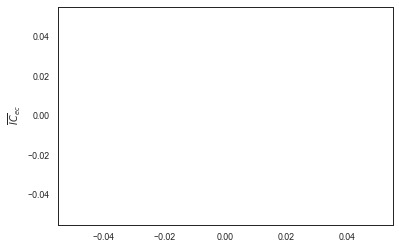

In [33]:
f, ax =plt.subplots()
ax.plot()
ax.set_ylabel(r' $\overline{IC}_{ec}$')


# Sucrose export

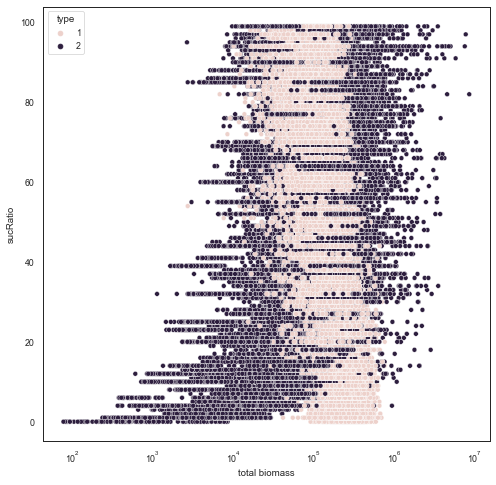

In [34]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='total biomass',y='sucRatio',hue='type',data=data,ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()


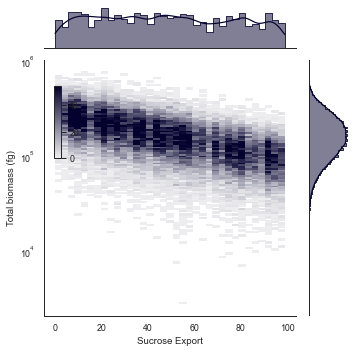

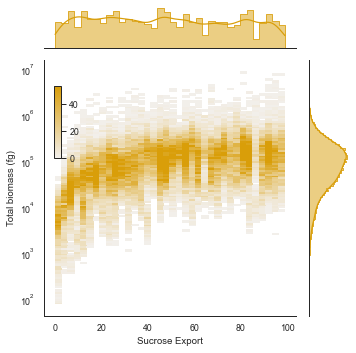

In [35]:

for i in [1,2]:
    data2 = data[data.type==i]
    g = sns.JointGrid(data=data2, x="sucRatio",y="total biomass", height=5,space=0.3)
    """     if i==1:
        g.fig.suptitle(r'$\it{S. elongatus}$')
    elif i ==2:
        g.fig.suptitle(r'$\it{E. coli W}$') """
    g.ax_joint.set(yscale="log")
    #g.ax_joint.set(yscale="log")
    cax = g.fig.add_axes([.15, .55, .02, .2])
    g.plot_joint(
        sns.histplot, 
        cmap=cmaps[i-1], cbar=True, cbar_ax=cax,pmax=.8)
    g.plot_marginals(sns.histplot, element="step", color=cmaps2[i-1],kde=True)
    g.ax_joint.set_xlabel(r'Sucrose Export')
    g.ax_joint.set_ylabel('Total biomass (fg)')
    g.savefig(f'../figures/sucR_{i}.png',dpi=600)

In [36]:
from matplotlib import transforms
def label_panel(ax, letter, *,
                offset_left=0.1, offset_up=0.1, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)

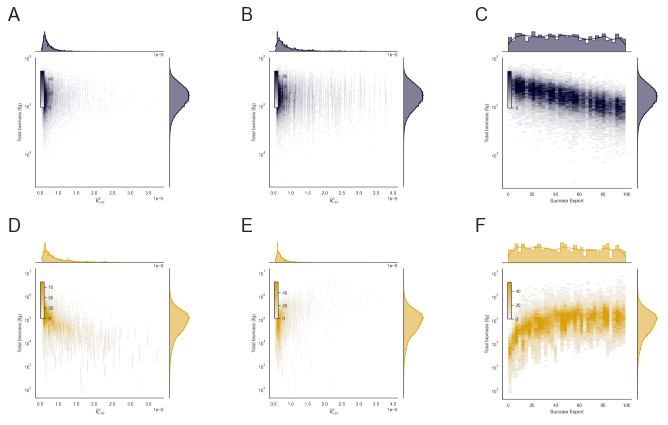

In [37]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
axes[0,0].imshow(mpimg.imread('../figures/IC1_1.png'))
axes[0,1].imshow(mpimg.imread('../figures/IC2_1.png'))
axes[0,2].imshow(mpimg.imread('../figures/sucR_1.png'))

axes[1,0].imshow(mpimg.imread('../figures/IC1_2.png'))
axes[1,1].imshow(mpimg.imread('../figures/IC2_2.png'))
axes[1,2].imshow(mpimg.imread('../figures/sucR_2.png'))
for ax in axes.ravel():
    ax.axis('off')

label_panel(axes[0,0],'A')
label_panel(axes[0,1],'B')
label_panel(axes[0,2],'C')
label_panel(axes[1,0],'D')
label_panel(axes[1,1],'E')
label_panel(axes[1,2],'F')
f.tight_layout()
f.savefig('../figures/spatial metrics.png',dpi=600)

Score:  1.0
Mean cross-validataion score: 0.25


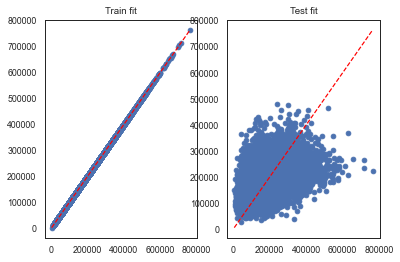

           0         1                         2
2   1.396091  0.004948                  sucRatio
13  0.068173  0.000281                        Z2
15  0.067542  0.000273                      Z2_1
10  0.066509  0.000359  Relative Neighbor Dist 2
22  0.042492  0.000198                  Log Inv2
17  0.041392  0.000123              LogNearest 2
20  0.039851  0.000158                      Inv2
11  0.038803  0.000448    Relative Neighbor Dist
9   0.036856  0.000214  Relative Neighbor Dist 1
12  0.036333   0.00017                        Z1
14  0.035482   0.00015                      Z1_2
4   0.033784  0.000289                 Nearest 2
7   0.033167  0.000358                       IC2
8   0.030325  0.000372                        IC
19  0.025295  0.000068                      Inv1
21  0.025213  0.000072                  Log Inv1
16  0.025143  0.000089              LogNearest 1
18   0.02473  0.000238                LogNearest
5   0.024604  0.000222          Nearest Neighbor
6   0.022539  0.0003

In [38]:
predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell'])) 

data2 = data[data.type==1]
X = data2[predictors]
y = data2['total biomass']
train_X1, test_X1, train_y1, test_y1 = train_test_split(X, y, train_size = 0.7, random_state = 42)

#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
model_et1 = ExtraTreesRegressor(n_estimators=500, random_state=100,n_jobs=-1)
model_et1.fit(train_X1, train_y1) 

pred_train_et1= model_et1.predict(train_X1)
pred_test_et1 = model_et1.predict(test_X1)

score = model_et1.score(train_X1, train_y1)
print("Score: ", score)
cv_scores = cross_val_score(model_et1, train_X1,train_y1,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y1,pred_train_et1)
axes[1].scatter(test_y1,pred_test_et1)
#Plot the diagonal line
d_line= np.arange(train_y1.min(), train_y1.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y1.min(), test_y1.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
#feats = pd.DataFrame([model_et.feature_importances_,X.columns]).T
#print(feats.sort_values(by=0,ascending=False))

result1 = permutation_importance(model_et1, train_X1, train_y1, random_state=0)
feats1 = pd.DataFrame([result1.importances_mean,result1.importances_std,X.columns]).T
print(feats1.sort_values(by=0,ascending=False))

Score:  1.0
Mean cross-validataion score: 0.25


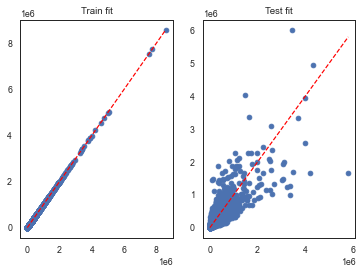

           0         1                         2
7   1.071744  0.008997                       IC2
2   0.452082  0.012985                  sucRatio
6   0.401624  0.008433                       IC1
8   0.061294  0.001702                        IC
4   0.034415  0.000401                 Nearest 2
17  0.016514  0.000176              LogNearest 2
22  0.016463  0.000189                  Log Inv2
13  0.008237  0.000124                        Z2
10  0.008017  0.000147  Relative Neighbor Dist 2
15  0.007986  0.000098                      Z2_1
3   0.007568  0.000087                 Nearest 1
20  0.007459  0.000147                      Inv2
16  0.007263  0.000033              LogNearest 1
21  0.006894  0.000075                  Log Inv1
9   0.004475  0.000197  Relative Neighbor Dist 1
12  0.004396  0.000185                        Z1
14  0.004393  0.000202                      Z1_2
19   0.00381   0.00005                      Inv1
11  0.003473  0.000088    Relative Neighbor Dist
5   0.003398  0.0001

In [39]:
data2 = data[data.type==2]
X = data2[predictors]
y = data2['total biomass']
train_X2, test_X2, train_y2, test_y2 = train_test_split(X, y, train_size = 0.7, random_state = 42)

#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
model_et2 = ExtraTreesRegressor(n_estimators=500, random_state=100,n_jobs=-1)
model_et2.fit(train_X2, train_y2) 

pred_train_et2= model_et2.predict(train_X2)
pred_test_et2 = model_et2.predict(test_X2)

score2 = model_et2.score(train_X2, train_y2)
print("Score: ", score)
cv_scores2 = cross_val_score(model_et2, train_X2,train_y2,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y2,pred_train_et2)
axes[1].scatter(test_y2,pred_test_et2)
#Plot the diagonal line
d_line= np.arange(train_y2.min(), train_y2.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y2.min(), test_y2.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
#feats = pd.DataFrame([model_et.feature_importances_,X.columns]).T
#print(feats.sort_values(by=0,ascending=False))

result2 = permutation_importance(model_et2, train_X2, train_y2, random_state=0)
feats2 = pd.DataFrame([result2.importances_mean,result2.importances_std,X.columns]).T
print(feats2.sort_values(by=0,ascending=False))

In [40]:
r2_score(test_y2,pred_test_et2)

0.6666026401325016

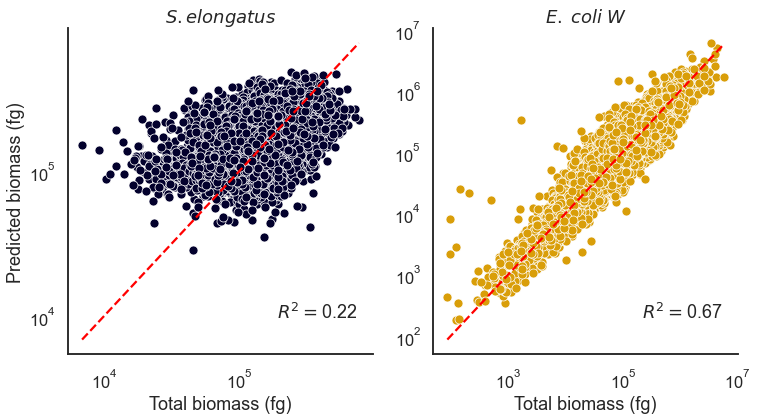

In [41]:
sns.set_theme(style="white")
sns.set_context('talk')
cmaps2 = ["#03012d","#d99e09"]
r2s = [r2_score(test_y1,pred_test_et1),r2_score(test_y2,pred_test_et2)]
f, axes = plt.subplots(ncols=2,figsize=(12,6))
#axes[0].scatter(test_y1,pred_test_et1)
sns.scatterplot(x=test_y1,y=pred_test_et1,ax=axes[0],color="#03012d")
sns.scatterplot(x=test_y2,y=pred_test_et2,ax=axes[1],color="#d99e09")
#axes[1].scatter(test_y2,pred_test_et2)
#Plot the diagonal line
d_line= np.arange(test_y1.min(), test_y1.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y2.min(), test_y2.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_ylabel('Predicted biomass (fg)')
for r2,ax in zip(r2s,axes.ravel()):
    ax.set_xlabel('Total biomass (fg)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.text(0.95,0.1,f'$R^2=${r2:.2f}',transform=ax.transAxes,verticalalignment='bottom', horizontalalignment='right')
axes[0].set_title(r'$\it{S. elongatus}$')
axes[1].set_title(r'$\it{E.}$ $\it{coli}$ $\it{W}$')
sns.despine()
f.savefig('../figures/biomass-prediction.pdf',bbox_inches='tight')